# MTA Analysis: Data Acquisition & Cleaning

### Setup
#### Import required libraries.

In [54]:
import pandas as pd
import os

from data_cleaning_utilities import convert_timestamp_to_mta_format, clean_hourly_turnstile_traffic, \
                                    get_mta_turnstile_data

### Data Acquisition
Load [MTA Turnstile Data](http://web.mta.info/developers/turnstile.html) and combine into a single dataframe. We chose to look at May/June data for the last 5 years because the event that our client needs to advertise for is at the beginning of the summer (end of June). Our assumption is that 2 months is an 
ideal time span for handing out fliers for an event.

In [2]:
df_turnstile_data = get_mta_turnstile_data(start='2015-05-02', end='2020-06-27', months_of_interest=[5, 6])

Save raw, unclean data as a pickle. Make processed data directory if does not already exist. 

In [3]:
if not os.path.isdir('processed_data'):
    os.mkdir('processed_data')
    
df_turnstile_data.to_pickle('processed_data/raw_mta_turnstile_data.pkl')

### Data Cleaning
Load pickled data.

In [4]:
df_mta_raw = pd.read_pickle('processed_data/raw_mta_turnstile_data.pkl')
df_mta_raw.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,REGULAR,5106961,1729784
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,REGULAR,5107250,1729858


Remove any whitespace from column names and initialize a new dataframe to store cleaned data.

In [5]:
df_mta_clean = df_mta_raw
df_mta_clean.columns = df_mta_clean.columns.str.replace(' ', '')

Determine if there are any NaN values.

In [6]:
df_mta_raw[df_mta_clean.isna()].count()

C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

No NaN values to filter.

Add `DATETIME` column to dataset.

In [7]:
df_mta_clean['DATETIME'] = pd.to_datetime(df_mta_clean['DATE'] + ' ' + df_mta_clean['TIME'])

Check if there are duplicates by determining if there are multiple readings for a given turnstile at a given time.

In [8]:
df_checking_duplicates = (df_mta_clean.groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"]).ENTRIES.count().reset_index()).sort_values('ENTRIES')
df_checking_duplicates

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-04-30 00:00:00,1
6896126,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-26 04:00:00,1
6896127,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-26 08:00:00,1
6896128,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-26 12:00:00,1
6896129,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-26 16:00:00,1
...,...,...,...,...,...,...
6410336,R101,R001,02-00-00,SOUTH FERRY,2018-05-23 09:00:00,2
2073816,JFK03,R536,00-00-05,JFK JAMAICA CT1,2015-05-14 05:00:00,2
4774408,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-16 16:00:00,2
4774415,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-17 08:00:00,2


In [9]:
df_checking_duplicates = df_checking_duplicates[df_checking_duplicates['ENTRIES'] == 2]
df_checking_duplicates

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
9359628,R518,R261,00-03-02,40 ST LOWERY ST,2017-06-05 08:00:00,2
5189785,N525,R142,01-00-03,DELANCEY/ESSEX,2019-05-11 05:00:00,2
811622,B020,R263,00-06-01,AVENUE H,2016-05-30 12:00:00,2
4290068,N329,R201,00-03-04,WOODHAVEN BLVD,2015-05-20 05:00:00,2
8513239,R290,R161,00-00-00,KINGSBRIDGE RD,2019-06-07 05:00:00,2
...,...,...,...,...,...,...
6410336,R101,R001,02-00-00,SOUTH FERRY,2018-05-23 09:00:00,2
2073816,JFK03,R536,00-00-05,JFK JAMAICA CT1,2015-05-14 05:00:00,2
4774408,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-16 16:00:00,2
4774415,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-17 08:00:00,2


Check to see what is causing the duplicate.

In [10]:
mask = (
    (df_mta_clean['C/A'] == 'R518') &
    (df_mta_clean['UNIT'] == 'R261') &
    (df_mta_clean['SCP'] == '00-03-02') &
    (df_mta_clean['STATION'] == '40 ST LOWERY ST') &
    (df_mta_clean['DATETIME'] == pd.to_datetime('2017-06-05 08:00:00'))
)
df_mta_clean[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
178845,R518,R261,00-03-02,40 ST LOWERY ST,7,IRT,06/05/2017,08:00:00,REGULAR,18778966,7453831,2017-06-05 08:00:00
178846,R518,R261,00-03-02,40 ST LOWERY ST,7,IRT,06/05/2017,08:00:00,RECOVR AUD,18778965,7453831,2017-06-05 08:00:00


Spot check randomly to see if REGULAR and RECOVR AUD readings are different.

In [11]:
mask = (
    (df_mta_clean['C/A'] == 'R290') &
    (df_mta_clean['UNIT'] == 'R161') &
    (df_mta_clean['SCP'] == '00-00-00') &
    (df_mta_clean['STATION'] == 'KINGSBRIDGE RD') &
    (df_mta_clean['DATETIME'] == pd.to_datetime('2019-06-07 05:00:00'))
)
df_mta_clean[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
169384,R290,R161,00-00-00,KINGSBRIDGE RD,4,IRT,06/07/2019,05:00:00,REGULAR,183445,164296,2019-06-07 05:00:00
169385,R290,R161,00-00-00,KINGSBRIDGE RD,4,IRT,06/07/2019,05:00:00,RECOVR AUD,183444,164296,2019-06-07 05:00:00


In [12]:
mask = (
    (df_mta_clean['C/A'] == 'N045') &
    (df_mta_clean['UNIT'] == 'R187') &
    (df_mta_clean['SCP'] == '01-00-02') &
    (df_mta_clean['STATION'] == '81 ST-MUSEUM') &
    (df_mta_clean['DATETIME'] == pd.to_datetime('2019-06-17 09:00:00'))
)
df_mta_clean[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
49121,N045,R187,01-00-02,81 ST-MUSEUM,BC,IND,06/17/2019,09:00:00,REGULAR,4343886,994027,2019-06-17 09:00:00
49122,N045,R187,01-00-02,81 ST-MUSEUM,BC,IND,06/17/2019,09:00:00,RECOVR AUD,4343885,994027,2019-06-17 09:00:00


In [13]:
df_mta_clean.DESC.value_counts()

REGULAR       10303603
RECOVR AUD       40700
Name: DESC, dtype: int64

Based on a spot check, it appears that where there are duplicates, the REGULAR and RECOVR AUD readings are identical.
We will assume that we can drop any duplicate entries (regardless of the type).

In [14]:
df_mta_clean.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

Confirm no duplicates.

In [15]:
(df_mta_clean.groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"]).ENTRIES.count().reset_index()).sort_values('ENTRIES')

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-04-30 00:00:00,1
6896138,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-28 04:00:00,1
6896139,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-28 08:00:00,1
6896140,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-28 12:00:00,1
6896141,R145,R032,00-00-00,TIMES SQ-42 ST,2018-05-28 16:00:00,1
...,...,...,...,...,...,...
3448070,N135,R385,01-03-01,ROCKAWAY BLVD,2015-06-25 17:00:00,1
3448071,N135,R385,01-03-01,ROCKAWAY BLVD,2015-06-25 21:00:00,1
3448072,N135,R385,01-03-01,ROCKAWAY BLVD,2015-06-26 01:00:00,1
3448065,N135,R385,01-03-01,ROCKAWAY BLVD,2015-06-24 21:00:00,1


Drop columns `DESC`. Supress errors.

In [16]:
df_mta_clean = df_mta_clean.drop("DESC", axis=1, errors="ignore")
df_mta_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,5106770,1729635,2015-04-25 00:00:00
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,5106810,1729649,2015-04-25 04:00:00
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,5106835,1729680,2015-04-25 08:00:00
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,5106961,1729784,2015-04-25 12:00:00
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,5107250,1729858,2015-04-25 16:00:00


Turnstile counts (entries and exits) are cumulative. In order to actually calculate the number of entries/exits per timestamp, some calculations need to be performed.

In [17]:
df_mta_clean.reset_index(inplace=True)
df_mta_clean[["PREV_DATETIME", "PREV_ENTRIES", "PREV_EXITS"]] = (
    df_mta_clean
    .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATETIME", "ENTRIES", "EXITS"]
    .apply(lambda grp: grp.shift(1)))

df_mta_clean.head()

<ipython-input-17-e48f0495b2aa>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mta_clean


,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS
0,0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,5106770,1729635,2015-04-25 00:00:00,NaT,NaN,NaN
1,1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,5106810,1729649,2015-04-25 04:00:00,2015-04-25 00:00:00,5106770.0,1729635.0
2,2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,5106835,1729680,2015-04-25 08:00:00,2015-04-25 04:00:00,5106810.0,1729649.0
3,3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,5106961,1729784,2015-04-25 12:00:00,2015-04-25 08:00:00,5106835.0,1729680.0
4,4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,5107250,1729858,2015-04-25 16:00:00,2015-04-25 12:00:00,5106961.0,1729784.0


In [18]:
df_mta_clean.drop('index', axis=1, inplace=True)

Since there is no hour previous to the first hour, this resulted in `NaN` for the first hour of data for each turnstile. Those rows should be dropped. This will also take care of any other `NaN` data.

In [19]:
df_mta_clean.dropna(axis=0, inplace=True)
df_mta_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,5106810,1729649,2015-04-25 04:00:00,2015-04-25 00:00:00,5106770.0,1729635.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,5106835,1729680,2015-04-25 08:00:00,2015-04-25 04:00:00,5106810.0,1729649.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,5106961,1729784,2015-04-25 12:00:00,2015-04-25 08:00:00,5106835.0,1729680.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,5107250,1729858,2015-04-25 16:00:00,2015-04-25 12:00:00,5106961.0,1729784.0
5,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,20:00:00,5107620,1729914,2015-04-25 20:00:00,2015-04-25 16:00:00,5107250.0,1729858.0


Calculates initial hourly entries and exits for each 4-hour timestamp.

In [20]:
df_mta_clean['HOURLY_ENTRIES'] = df_mta_clean["ENTRIES"] - df_mta_clean["PREV_ENTRIES"]
df_mta_clean['HOURLY_EXITS'] = df_mta_clean["EXITS"] - df_mta_clean["PREV_EXITS"]
df_mta_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,5106810,1729649,2015-04-25 04:00:00,2015-04-25 00:00:00,5106770.0,1729635.0,40.0,14.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,5106835,1729680,2015-04-25 08:00:00,2015-04-25 04:00:00,5106810.0,1729649.0,25.0,31.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,5106961,1729784,2015-04-25 12:00:00,2015-04-25 08:00:00,5106835.0,1729680.0,126.0,104.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,5107250,1729858,2015-04-25 16:00:00,2015-04-25 12:00:00,5106961.0,1729784.0,289.0,74.0
5,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,20:00:00,5107620,1729914,2015-04-25 20:00:00,2015-04-25 16:00:00,5107250.0,1729858.0,370.0,56.0


Calculate median entry and exit values to replace outlier data issues. _Using DAYOFWEEK/TIME over the DATE/TIME, as the turnstile entries vary by day of week, so the median will be more accurate._

In [21]:
df_mta_clean['DAYOFWEEK'] = df_mta_clean['DATETIME'].dt.dayofweek
mta_medians = (df_mta_clean
                    .groupby(["C/A", "UNIT", "SCP", "STATION", "DAYOFWEEK", "TIME"])
                    .agg(ENTRIES_MEDIAN=('HOURLY_ENTRIES', 'median'), EXITS_MEDIAN=('HOURLY_EXITS', 'median'))
                    .reset_index()
              )

In [22]:
df_mta_clean = df_mta_clean.merge(mta_medians, how="left", on=["C/A", "UNIT", "SCP", "STATION", "DAYOFWEEK", "TIME"])

We must determine a reasonable number for the "reset limit", which is an average approximation of when turnstiles' entry/exit counts tend to reset to 0. Instead of determining a reset limnit of the raw turnstile counts, we instead  calculate the net hourly entries and determine what is a reasonable maximum. Plotting the distribution of the absolute value of net hourly entries informed our decision to set a safe reset limit of `4000`.

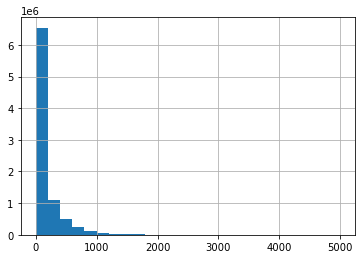

In [60]:
abs(df_mta_clean['HOURLY_ENTRIES']).hist(bins=25, range=[0, 5000])

In [24]:
df_mta_clean['HOURLY_ENTRIES'] = df_mta_clean.apply(clean_hourly_turnstile_traffic, axis=1, reset_limit=4000)
df_mta_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,DAYOFWEEK,ENTRIES_MEDIAN,EXITS_MEDIAN
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,5106810,1729649,2015-04-25 04:00:00,2015-04-25 00:00:00,5106770.0,1729635.0,40.0,14.0,5,31.0,7.0
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,5106835,1729680,2015-04-25 08:00:00,2015-04-25 04:00:00,5106810.0,1729649.0,25.0,31.0,5,21.0,26.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,5106961,1729784,2015-04-25 12:00:00,2015-04-25 08:00:00,5106835.0,1729680.0,126.0,104.0,5,110.0,99.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,5107250,1729858,2015-04-25 16:00:00,2015-04-25 12:00:00,5106961.0,1729784.0,289.0,74.0,5,258.0,71.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,20:00:00,5107620,1729914,2015-04-25 20:00:00,2015-04-25 16:00:00,5107250.0,1729858.0,370.0,56.0,5,371.0,54.0


In [25]:
df_mta_clean['HOURLY_EXITS'] = df_mta_clean.apply(clean_hourly_turnstile_traffic, axis=1, reset_limit=4000, 
                                                  entries=False)
df_mta_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,DAYOFWEEK,ENTRIES_MEDIAN,EXITS_MEDIAN
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,5106810,1729649,2015-04-25 04:00:00,2015-04-25 00:00:00,5106770.0,1729635.0,40.0,14.0,5,31.0,7.0
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,5106835,1729680,2015-04-25 08:00:00,2015-04-25 04:00:00,5106810.0,1729649.0,25.0,31.0,5,21.0,26.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,5106961,1729784,2015-04-25 12:00:00,2015-04-25 08:00:00,5106835.0,1729680.0,126.0,104.0,5,110.0,99.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,5107250,1729858,2015-04-25 16:00:00,2015-04-25 12:00:00,5106961.0,1729784.0,289.0,74.0,5,258.0,71.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,20:00:00,5107620,1729914,2015-04-25 20:00:00,2015-04-25 16:00:00,5107250.0,1729858.0,370.0,56.0,5,371.0,54.0


Since we set remaining outlier values that weren't fixed with the median to NaN, we need to drop NaN values again

In [26]:
df_mta_clean.dropna(axis=0, inplace=True)

While exploring the data, we discovered that there were some station name inconsistencies across different years. If you group the data by station and year, this becomes obvious upon inspection.

In [35]:
df_mta_clean['YEAR'] = df_mta_clean['DATETIME'].dt.year
df_mta_stationyear = df_mta_clean.groupby(['STATION','YEAR']).sum()

In [39]:
df_mta_stationyear[0:6]

ENTRIES         EXITS  PREV_ENTRIES    PREV_EXITS  \
STATION YEAR                                                            
1 AV    2016   510628969802  902689717133  5.107788e+11  9.047015e+11   
        2017   527691920672  498980565534  5.260637e+11  4.988059e+11   
        2018  1151589758507  616400741552  1.151591e+12  6.164134e+11   
        2019   560208135692  579926355901  5.618318e+11  5.800877e+11   
        2020   158332975480  163908541062  1.592866e+11  1.649046e+11   
1 AVE   2015   339333277761  352958665221  3.383938e+11  3.519720e+11   

              HOURLY_ENTRIES  HOURLY_EXITS  DAYOFWEEK  ENTRIES_MEDIAN  \
STATION YEAR                                                            
1 AV    2016       1257542.0     1281789.0      10074       1075220.0   
        2017       1070221.0     1117750.0      10070       1070329.0   
        2018       1303905.5     1426875.5      11370       1209529.0   
        2019        948913.5     1073266.5      11750       1226415.0   
        2020        135061.5      199546.5      21000       1101160.0   
1 AVE   2015       1248551.0     1294462.0      11400       1302534.0   

              EXITS_MEDIAN  
STATION YEAR                
1 AV    2016     1130268.5  
        2017     1127128.0  
        2018     1276442.0  
        2019     1293026.0  
        2020     1284758.5  
1 AVE   2015     1387108.0

In [42]:
df_mta_stationyear[-6:]

ENTRIES      EXITS  PREV_ENTRIES   PREV_EXITS  \
STATION    YEAR                                                      
ZEREGA AV  2016  18072714893  253145336  1.807259e+10  253036880.0   
           2017  18164776620  446599409  1.816464e+10  445992639.0   
           2018  20572469256  612751656  2.057197e+10  612503352.0   
           2019    707899469  345345993  7.604370e+08  346029843.0   
           2020    957850414  586580468  9.572401e+08  585988400.0   
ZEREGA AVE 2015  16060719010  197933020  1.600886e+10  200196497.0   

                 HOURLY_ENTRIES  HOURLY_EXITS  DAYOFWEEK  ENTRIES_MEDIAN  \
STATION    YEAR                                                            
ZEREGA AV  2016        120343.0      108456.0       6018        124871.0   
           2017        129641.0      118065.5       5958        123879.5   
           2018        142825.0      131914.0       6802        139286.5   
           2019        142733.0      134975.5       6800        139441.5   
           2020         26213.0       33227.5       6774        139260.5   
ZEREGA AVE 2015        120084.0      113561.0       6801        124388.0   

                 EXITS_MEDIAN  
STATION    YEAR                
ZEREGA AV  2016      113317.5  
           2017      110905.0  
           2018      127014.5  
           2019      127372.5  
           2020      127022.5  
ZEREGA AVE 2015      117144.0

In [44]:
df_mta_stationyear[50:56]

ENTRIES         EXITS  PREV_ENTRIES    PREV_EXITS  \
STATION YEAR                                                           
121 ST  2015    2754907526    2347118879  2.754765e+09  2.347040e+09   
        2016    4688582729    2240114811  4.687773e+09  2.239672e+09   
        2017    2569611834    2036950232  2.569136e+09  2.036762e+09   
        2018    3461505764    2724184560  3.461074e+09  2.723934e+09   
        2019  737019245541  198501448545  7.352243e+11  1.979820e+11   
        2020  737236933901  198644627902  7.372364e+11  1.986443e+11   

              HOURLY_ENTRIES  HOURLY_EXITS  DAYOFWEEK  ENTRIES_MEDIAN  \
STATION YEAR                                                            
121 ST  2015        142625.0       79331.0       5660        105255.5   
        2016        125781.0       65743.0       5072         93211.0   
        2017         40811.0        7472.0       4048         72145.5   
        2018         69445.0       29367.0       5690        105128.0   
        2019        125690.5       85421.5       6780        108088.5   
        2020         26269.5       21070.5       6768        108082.5   

              EXITS_MEDIAN  
STATION YEAR                
121 ST  2015       43579.0  
        2016       39643.5  
        2017       22553.5  
        2018       43742.5  
        2019       57794.5  
        2020       57896.0

In [47]:
df_mta_stationyear[704:710]

ENTRIES       EXITS  PREV_ENTRIES    PREV_EXITS  \
STATION     YEAR                                                       
ALABAMA AV  2016  2916640432  3127831862  2.916506e+09  3.127707e+09   
            2017  2188627434  2396641044  2.190741e+09  2.398755e+09   
            2018  2753923747  2986041543  2.753170e+09  2.985292e+09   
            2019  2992450518  3235645674  2.991787e+09  3.234947e+09   
            2020  3207660706  3475954548  3.207131e+09  3.475353e+09   
ALABAMA AVE 2015  2915847415  3176845650  2.915697e+09  3.176711e+09   

                  HOURLY_ENTRIES  HOURLY_EXITS  DAYOFWEEK  ENTRIES_MEDIAN  \
STATION     YEAR                                                            
ALABAMA AV  2016        134652.0      124554.0       3024        111358.0   
            2017        125211.0      125023.0       3036        111635.0   
            2018        125861.0      128987.0       3426        124770.0   
            2019        113024.0      119301.0       3402        124852.5   
            2020         33995.0       51703.0       3402        124852.5   
ALABAMA AVE 2015        150402.0      134807.0       3387        150840.0   

                  EXITS_MEDIAN  
STATION     YEAR                
ALABAMA AV  2016      113888.0  
            2017      114299.0  
            2018      127719.0  
            2019      127818.0  
            2020      127818.0  
ALABAMA AVE 2015      134917.0

Based on a spot check it appears that for some naming conventions, the street names are different between 2015 and 2016 on. It would be exhaustive to determine all of these changes, and since 2016-2020 is sufficient, we decided to simply get rid of 2015 data to avoid any issues with grouping by station when visualizing the data.

In [50]:
df_mta_clean = df_mta_clean[df_mta_clean['YEAR'] != 2015]
df_mta_clean[df_mta_clean['YEAR'] == 2015]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,DAYOFWEEK,ENTRIES_MEDIAN,EXITS_MEDIAN,YEAR


Persist the final cleaned dataset to a pickle for use in `Data Analysis & Visualization.ipynb`.

In [53]:
df_mta_clean.to_pickle('processed_data/cleaned_mta_turnstile_data.pkl')